In [7]:
import joblib
import pandas as pd
import os
import numpy as np
import pickle
import sklearn
import gensim
from sklearn.feature_extraction.text import CountVectorizer


# Utility Functions Here!

In [12]:
# a utility function to display the topics and for each topic we choose the top most frequent words
def display_topics(model, feature_names, num_top_words):
    for topic_id, topic in enumerate(model.components_):
        print(f'Topic {topic_id}')
        print(' '.join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))

# Show top n keywords for each topic
def show_topics(vectorizer, lda_model, n_words=15):
    keywords = np.array(vectorizer.get_feature_names_out())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

def show_doc_topic_matrix(model, vecs, num_doc_to_show = 10, to_styler=True):
    # model = a trained sklearn lda model
    # vecs = output from the CountVectorizer transform
    lda_output = model.transform(vecs)
    # Make the pandas dataframe
    df_document_topic = pd.DataFrame(np.round(lda_output, 6), 
                                     columns=[f'topic{i}' for i in range(model.n_components)], 
                                     index=[f'doc{i}' for i in range(vecs.shape[0])])

    # Get dominant topic for each document
    df_document_topic['dominant_topic'] = np.argmax(df_document_topic.values, axis=1)



    # apply style and return the dataframe
    df_out = df_document_topic.head(num_doc_to_show)
    if to_styler:
        return df_out.style.applymap(color_green).applymap(make_bold)
    else:
        return df_out

# function to show exponential value of expectation of log topic word distribution = exp(E[log(beta)])

def show_topic_token_matrix(model, feature_names, num_top_words = 10):
    # model = a trained sklearn lda model
    # feature_names = fitted CountVectorizer.get_feature_names_out()
    top_tokens_per_topic = []

    for topic_id, topic in enumerate(model.components_):
        topic_token_p = [(topic_id, feature_names[i], topic[i]) for i in topic.argsort()[:-num_top_words - 1:-1]]
        top_tokens_per_topic.extend(topic_token_p)

    return pd.DataFrame(top_tokens_per_topic, columns=['topic', 'token', 'e_exp_log_beta'])
    
# Styling
def color_green(val):
    if 0 < val < 1:
        color = 'black' if val > .1 else 'grey'
        return f'color: {color}'

def make_bold(val):
    if 0 < val < 1:
        weight = 'bold' if val > .1 else 'lighter'
        return f'font-weight: {weight}'
    


# Initialize Vectorizer

In [13]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # min occurrences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=False,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )


X_train = pd.read_pickle("X_Train.pkl")
df_filtered_lemmatized = X_train["text_lemmatized"].tolist()

stop_list = ("suicidal", "suicide", "aah", "fuck")
df_filtered_lemmatized_removeSuicide = [[w for w in doc if w not in stop_list] for doc in df_filtered_lemmatized]
df_filtered_lemmatized_joined = [' '.join(x) for x in df_filtered_lemmatized_removeSuicide]  # joined to fit CountVectorizer
train1_vecs = vectorizer.fit_transform(df_filtered_lemmatized_joined)
feature_names = vectorizer.get_feature_names_out()

In [ ]:
print(feature_names[:20])

# Load Model

In [14]:
#print('The joblib version is {}.'.format(joblib.__version__))
lda_suicidal_model = joblib.load('suicidal_lda_model.jl')
lda_output = lda_suicidal_model.get_feature_names_out()
print(lda_output)

['latentdirichletallocation0' 'latentdirichletallocation1'
 'latentdirichletallocation2' 'latentdirichletallocation3'
 'latentdirichletallocation4' 'latentdirichletallocation5'
 'latentdirichletallocation6' 'latentdirichletallocation7'
 'latentdirichletallocation8' 'latentdirichletallocation9']


In [15]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(lda_suicidal_model.components_)
# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names_out()
topicnames = ["Topic" + str(i) for i in range(lda_suicidal_model.n_components)]
df_topic_keywords.index = topicnames
# View
df_topic_keywords.head()

,aaron,aba,aback,abandon,abandoned,abandonment,abdomen,abdominal,abhor,abhorrent,...,zine,zing,zip,zola,zoloft,zombie,zone,zoo,zoom,zzz
Topic0,0.100020,13.366476,0.100034,0.100022,0.100038,0.100016,0.100027,0.100008,0.100190,0.100026,...,0.100023,0.100019,0.100030,19.476813,0.100039,0.100029,0.100042,0.100025,0.100085,0.100045
Topic1,0.100028,0.100012,0.100014,27.624273,0.100021,0.100022,0.100013,0.100021,0.100254,0.100040,...,0.100039,0.100015,0.100070,0.100049,0.100044,30.276509,0.100034,0.100026,0.100039,0.100010
Topic2,0.100057,0.100016,0.100016,0.100043,0.100035,32.564610,0.100015,0.100006,0.100130,0.100078,...,0.100023,0.100017,0.100033,0.100013,0.100019,1.147279,0.100027,0.100045,0.100024,0.100019
Topic3,0.100045,0.100005,0.100082,16.826295,0.100045,0.100021,0.100035,0.100021,0.100023,0.100041,...,0.100057,0.100017,0.100104,0.100060,0.100042,0.100034,90.665542,0.100030,0.100024,10.094360
Topic4,16.022687,0.100013,0.100048,98.769030,0.100035,0.100032,0.100024,0.100014,0.100208,0.100099,...,25.099943,25.419076,0.100043,0.100053,0.100026,68.788442,0.100039,0.100061,0.100035,0.100015


In [16]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_suicidal_model.score(train1_vecs))
# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_suicidal_model.perplexity(train1_vecs))
# See model parameters
print(lda_suicidal_model.get_params())

Log Likelihood:  -39680646.58411444
Perplexity:  1089.2723041878169
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'online', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 10, 'n_jobs': None, 'perp_tol': 0.1, 'random_state': None, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


# Predicting Topic


In [20]:
#!spacy download en_core_web_sm

# Define function to predict topic for a given text document.
#!pip install -U spacy
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']): #'NOUN', 'ADJ', 'VERB', 'ADV'
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
def predict_topic(model, vectorizer, text):
    global sent_to_words
    global lemmatization
    
# Step 1: Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))
# Step 2: Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
# Step 3: Vectorize transform
    mytext_4 = vectorizer.transform(mytext_3)
# Step 4: LDA Transform
    topic_probability_scores = model.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), 0:20].values.tolist()
    
    # Step 5: Infer Topic
    infer_topicNo = np.argmax(topic_probability_scores)
    infer_topic = df_topic_keywords.iloc[infer_topicNo, 0]
    themes = ["School", "Career", "Relationships", "Sleep / Insomnia", "Social Anxiety", "Love", "Communication", "Experiences", "Self-Harm", "Negative emotions / Depression"]
    #topic_guess = df_topic_keywords.iloc[np.argmax(topic_probability_scores), Topics]
    return themes[infer_topicNo], topic, infer_topicNo, topic_probability_scores


In [21]:
show_doc_topic_matrix(lda_suicidal_model, train1_vecs)

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda_suicidal_model)

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,school,college,high,parent,class,year,grade,fail,game,study,play,graduate,university,video,start
Topic 1,job,work,live,money,pay,month,time,need,try,help,week,year,home,day,car
Topic 2,life,love,live,world,want,hate,die,wish,end,good,people,hope,person,deserve,pain
Topic 3,want,head,die,day,night,sleep,kill,think,cut,wake,pill,try,ill,stop,time
Topic 4,life,people,thing,way,experience,live,world,change,think,mind,point,self,fear,believe,society
Topic 5,like,people,friend,girl,look,shit,guy,hate,amp,talk,ugly,woman,lonely,stupid,say
Topic 6,help,know,need,talk,tell,post,say,ask,write,friend,sure,read,sorry,thank,thought
Topic 7,year,time,live,friend,tell,start,know,want,didst,day,thing,month,think,like,family
Topic 8,pain,kill,jump,attempt,hospital,doctor,plan,way,method,pill,overdose,bridge,painful,train,cause
Topic 9,feel,want,like,live,know,think,life,people,anymore,time,try,thing,kill,bad,die


# Prediction

In [23]:
mytext = [""" I've been struggling for years and I'm afraid. Through these past years thoughts of suicide, fear, anxiety I'm so close to my limit . I've been quiet for so long and I'm too scared to come out to my family about these feelings. 
About 3 years ago  losing my aunt triggered it all. Everyday feeling hopeless , lost, guilty, and remorseful over her and all the things I've done in my life,but thoughts like these with the little I've experienced in life? Only time I've revealed these feelings to my family is when I broke down where they saw my cuts. 
Watching them get so worried over something I portrayed as an average day made me feel absolutely dreadful. They later found out I was an attempt survivor from attempt OD(overdose from pills) and attempt hanging. 
All that happened was a blackout from the pills and I never went through with the noose because I'm still so afraid. During my first therapy I was diagnosed with severe depression, social anxiety, and a eating disorder.
I was later transferred to a fucken group therapy for some reason which made me feel more anxious. Eventually before my last session with a 1 on 1 therapy she showed me my results from a daily check up on my feelings(which was a 2 - step survey for me and my mom/dad )
Come to find out as I've been putting feeling horrible and afraid/anxious everyday , my mom has been doing I've been doing absolutely amazing with me described as happiest shits ever seen me, therapy has helped him 
I eventually was put on Sertaline (anti anxiety or anti depression I'm sorry I forgot) but I never finished my first prescription nor ever found the right type of anti depressant because my mom thought 
I only wanted the drugs so she took me off my recommended pill schedule after ~3 week and stopped me from taking them. All this time I've been feeling worse afraid of the damage/ worry I've caused them even more. 
Now here with everything going on, I'm as afraid as I've ever been . I've relapsed on cutting and have developed severe insomnia . Day after day feeling more hopeless, worthless questioning why am I still here? 
What's my motivation to move out of bed and keep going? I ask these to myself nearly every night almost having a break down everytime. 
Please Please Please someone.. anyone help me.
I'm so scared I might do something drastic, I've been shaped by fear and anxiety. Idk what to do anymore

         """]

infer_topic, topic, infer_topicNo, prob_scores = predict_topic(lda_suicidal_model, vectorizer = vectorizer, text = mytext)

print("Topic: " + str(infer_topicNo) + " - " +  infer_topic)
print(topic)

Topic: 7 - Experiences
['year', 'time', 'live', 'friend', 'tell', 'start', 'know', 'want', 'didst', 'day', 'thing', 'month', 'think', 'like', 'family']


# Trying to cluster

In [28]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD


clusters = KMeans(n_clusters=10, random_state=100).fit_predict(lda_suicidal_model.components_)
# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_suicidal_model.components_)
# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]
# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))
# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0. -0.  0.]]
Perc of Variance Explained: 
 [0.75 0.1 ]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Text(0.5, 1.0, 'Segregation of Topic Clusters')

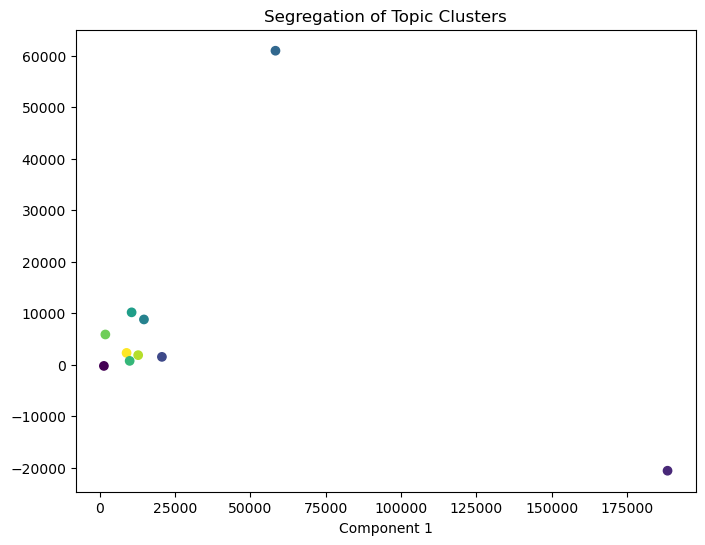

In [34]:
import matplotlib.pyplot as plot

plot.figure(figsize=(8,6))
plot.scatter(x, y, c=clusters)
plot.xlabel('Component 2')
plot.xlabel('Component 1')
plot.title("Segregation of Topic Clusters", )

In [37]:
from gensim.models import CoherenceModel
import gensim.corpora as corpora

def get_Cv(model, df_column):
  topics = model.components_

  n_top_words = 20
  texts = [[word for word in doc.split()] for doc in df_column]

  # create the dictionary
  dictionary = corpora.Dictionary(texts)
  # Create a gensim dictionary from the word count matrix

  # Create a gensim corpus from the word count matrix
  corpus = [dictionary.doc2bow(text) for text in texts]

  feature_names = [dictionary[i] for i in range(len(dictionary))]

  # Get the top words for each topic from the components_ attribute
  top_words = []
  for topic in topics:
      top_words.append([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])

  coherence_model = CoherenceModel(topics=top_words, texts=texts, dictionary=dictionary, coherence='c_v')
  coherence = coherence_model.get_coherence()
  return coherence

In [40]:
coherence = get_Cv(df_column=df_filtered_lemmatized_joined, model=lda_suicidal_model)

In [41]:
print(coherence)

0.6790435719409318
